# Subband Hamiltonian
I will use this notebook to write the Hamiltonian for a l-subband and use it to find the critical current vs flux relationship.

$$ H_l = \begin{pmatrix} H_e - \mu_{e,l} & \Delta \\ \Delta^{\dagger} & -H_e^* + \mu_{h,l} \end{pmatrix} $$

where $H_e$ is a 1D free electron Hamiltonian, $\mu_{e,l} = \frac{\hbar^2}{2 m R^2} (l - \Phi)^2, \mu_{e,h} = \frac{\hbar^2}{2 m R^2} (l + \Phi)^2$

In [64]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import scipy.special
import scipy.integrate
import time

In [4]:
%load_ext line_profiler

In [5]:
# create the Hamiltonian matrix

def calc_subband_hamiltonian(params):
    '''
    Returns the Hamiltonian in the real space basis.
    params is a dict with the following information:
        N_z : number of points along z
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
        flux : axial flux in h/e units
        Delta : order parameter
        l : subband index
    '''
    N_z = params['N_z']
    t_z = params['t_z']
    t_phi = params['t_phi']
    mu = params['mu']
    flux = params['flux']
    Delta = params['Delta']
    l = params['l']
  
    mu_e = mu - t_phi*(l - flux)**2
    mu_h = mu - t_phi*(l + flux)**2
    
    def calc_matrix_element(z1,z2):
        '''
        Returns the matrix element between two real space points x and y
        '''
        # onsite element
        if z1 == z2:
            diag_ele = 2*t_z 
            return np.array([[diag_ele - mu_e,Delta],[np.conj(Delta),-diag_ele+mu_h ]])
        # z hopping
        elif abs(z1-z2) == 1:
            return np.array([[-t_z,0],[0,t_z]])
        else:
            return np.array([[0,0],[0,0]])
    
    H_list = [calc_matrix_element(x,y) for x in range(N_z) for y in range(N_z)]
    H = np.array(H_list).reshape((N_z,N_z,2,2))
    
    # magic to flatten the Hamiltonian
    # Are you wathing closely?
    H = np.array([H[x,:,y,:].flatten() for x in range(H.shape[0]) for y in range(H.shape[2])])\
    .flatten().reshape(2*N_z,2*N_z)
    
    return H

In [6]:
# surface Green's funciton routines
# ordinary iteration schemes will be used

def calc_surface_g(E,alpha,beta,eta,eps = 1e-8,max_iter=100000,kappa=0.5):
    '''
    Return the surface Green's function at energy E 
   
    eta is used to calculated the Green's function
    eps controls the accuracy
    
    Returns the surface Green's function as a solution of the recursive relation 
    g = ((E + 1j*eta) - alpha - beta'*g*beta)^-1
    '''
    # conv here to avoid problems later
    E = np.array(E)
    
    
    def func_g(g,E,alpha,beta,eta):
        return np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(alpha.shape[0])- alpha - beta @ g @ np.conj(beta).T)
   
    g0 = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    g = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    
    err_vec = []
    for i in range(max_iter):
        g = func_g(g,E,alpha,beta,eta)
        g = ((1-kappa)*g + kappa*g0)
        err = np.linalg.norm(g - g0)/len(E)
        err_vec.append(err)
        g0 = np.copy(g)
        if err < eps:
            break
    return g

In [19]:
def calc_sns_negf(E,params):
    '''
    Returns the G,A,Sigma matrices for SNS device. The chemical potential will be assumed to same everywhere and
    no bias is present across the device.
    params dict takes in these parameters:
        N_z : number of points along z in the normal region
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
        Delta_1 : superconducting parameter 1
        Delta_2 : superconducting parameter 2
        eta : imaginary 0+ added for convergence
        flux : axial flux in h/e units
        l : subband index
    '''
    N_z = params['N_z']
    t_z = params['t_z']
    t_phi = params['t_phi']
    Delta_1 = params['Delta_1']
    Delta_2 = params['Delta_2']
    mu = params['mu']
    eta = params['eta']
    flux = params['flux']
    kT = params['kT']
    l = params['l']
  
    mu_e = mu - t_phi*(l - flux)**2
    mu_h = mu - t_phi*(l + flux)**2
    
    # create alpha/beta hamiltonians for S regions
    # calc surface Green's function
   
    params_S1 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z, "Delta" : Delta_1, "mu" : mu,"flux" : flux, "l" : 0}
    H_S1 = calc_subband_hamiltonian(params_S1)   
    surface_dof = 2
    alpha_1 = H_S1[:surface_dof,:surface_dof]
    beta_1 = H_S1[:surface_dof,surface_dof:2*surface_dof]
    g_1 = calc_surface_g(E,alpha_1,beta_1,eta)
    
    params_S2 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z, "Delta" : Delta_2, "mu" : mu,"flux" : flux, "l" : 0}
    H_S2 = calc_subband_hamiltonian(params_S2)   
    surface_dof = 2
    alpha_2 = H_S2[:surface_dof,:surface_dof]
    beta_2 = H_S2[:surface_dof,surface_dof:2*surface_dof]
    g_2 = calc_surface_g(E,alpha_2,beta_2,eta)
    
    
    # create Hamiltonian for N region
    params_N = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z, "Delta" : 0, "mu" : mu,"flux" : flux, "l" : l}
    H_mat = calc_subband_hamiltonian(params_N)
    
    #number of dof in a layer
    N_dof_lat = 2
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    # the only non-zero elements in sigma
    sigma_mini_1 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_1@beta_layer
    sigma_mini_2 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_2@beta_layer
    
    sigma_1 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_1[:,:N_dof_lat,:N_dof_lat] = sigma_mini_1
    gamma_1 = 1j*(sigma_1 - np.transpose(np.conj(sigma_1),(0,2,1)))
    
    sigma_2 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_2[:,-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
    gamma_2 = 1j*(sigma_2 - np.transpose(np.conj(sigma_2),(0,2,1)))
    
    # NEGF matrices
    G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)
    
    A = 1j*(G - np.transpose(np.conj(G),(0,2,1))) 
    dos = np.real(np.trace(A,axis1=-2,axis2=-1))
    
    def fermi(E,kT):
        return scipy.special.expit(-E/kT)
    
    def generate_fermi_matrix(E,mu_e,mu_h,mu,kT):
        return np.array([[[fermi(ele - mu_e+mu,kT),0],[0,fermi(ele + mu_h-mu,kT)]] for ele in E])
        
    F1 = np.kron(np.eye(N_z),generate_fermi_matrix(E,mu,mu,mu,kT))
    F2 = np.kron(np.eye(N_z),generate_fermi_matrix(E,mu,mu,mu,kT))
    sigma_in = np.matmul(gamma_1,F1) + np.matmul(gamma_2,F2)
    
    G_n = np.matmul(G,np.matmul(sigma_in,np.transpose(np.conj(G),(0,2,1))))
    
    #I_mat = 1j*(np.matmul(G_n[:N_dof_lat,N_dof_lat:2*N_dof_lat],beta_layer) \
    #         - np.matmul(G_n[N_dof_lat:2*N_dof_lat,:N_dof_lat],beta_layer))
    I_mat = 1j*(np.matmul(H_mat,G_n) - np.matmul(G_n,H_mat))
    # current = electron current - hole current
    I = np.real(np.trace(I_mat[:,0:2:2,0:2:2]-I_mat[:,1:2:2,1:2:2],axis1=-1,axis2=-2))
    
    return G,A,dos,I

In [20]:
def integrate_current(E_vec,I_vec):
    return scipy.integrate.simps(I_vec,E_vec) 

def calc_I_phi(params,E_vec,phi_vec):
    I_phi = []
    for phi in phi_vec:
        params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
        G,A,dos,I = calc_sns_negf(E_vec,params)
        I_phi.append(integrate_current(E_vec,I))
    I_phi = np.array(I_phi)
    return I_phi

In [9]:
def calc_critical_current(phi_vec,I_phi):
    '''
    Returns the critical current value given I(phi) and the critical phase
    '''
    arg_max = np.argmax(I_phi)
    I_c = I_phi[arg_max]
    return I_c,phi_vec[arg_max]

# Experiments

In [52]:
# Critical current vs flux for a single l subband
params = {
    "N_z" : 20,
    "t_z" : 25e-3,
    "t_phi" : 2e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 30e-3,
    "flux" : 0.0,
    "kT" : 1e-5
}

print("l = 1")
params["l"] = 1

E_vec = np.linspace(-2e-3,2e-3,100)
phi_vec = np.linspace(0,2*np.pi,100)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

flux_vec = np.linspace(0,3,100)
I_arr = []
for flux in flux_vec:
    params['flux'] = flux
    print(flux)
    I_arr.append(calc_I_phi(params,E_vec,phi_vec))
I_arr = np.array(I_arr)

I_c = np.array([calc_critical_current(phi_vec,I) for I in I_arr])

l = 1
0.0
0.030303030303030304
0.06060606060606061
0.09090909090909091
0.12121212121212122
0.15151515151515152
0.18181818181818182
0.21212121212121213
0.24242424242424243
0.2727272727272727
0.30303030303030304
0.33333333333333337
0.36363636363636365
0.3939393939393939
0.42424242424242425
0.4545454545454546
0.48484848484848486
0.5151515151515151
0.5454545454545454
0.5757575757575758
0.6060606060606061
0.6363636363636364
0.6666666666666667
0.696969696969697
0.7272727272727273
0.7575757575757576
0.7878787878787878
0.8181818181818182
0.8484848484848485
0.8787878787878788
0.9090909090909092
0.9393939393939394
0.9696969696969697
1.0
1.0303030303030303
1.0606060606060606
1.0909090909090908
1.1212121212121213
1.1515151515151516
1.1818181818181819
1.2121212121212122
1.2424242424242424
1.2727272727272727
1.303030303030303
1.3333333333333335
1.3636363636363638
1.393939393939394
1.4242424242424243
1.4545454545454546
1.4848484848484849
1.5151515151515151
1.5454545454545454
1.5757575757575757
1.6060

Text(0.5,1,'Current-Phase vs flux')

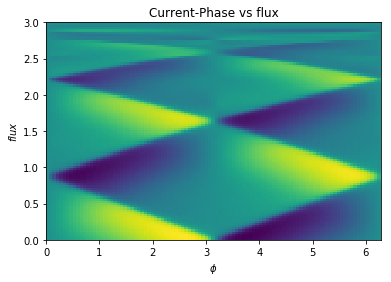

In [63]:
XX,YY = np.meshgrid(phi_vec,flux_vec)
plt.pcolor(XX,YY,I_arr)
plt.xlabel(r"$\phi$")
plt.ylabel(r"$flux$")
plt.title("Current-Phase vs flux")

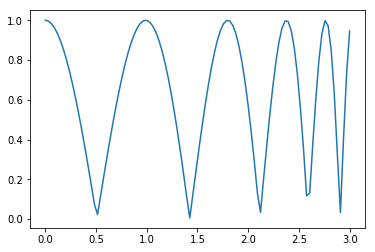

In [54]:
# semiclassical result
def calc_I_c_semiclassical(flux_vec,params):
    L = params['N_z']*np.sqrt(1.7/params['t_z'])
    healing_length = 1.287*np.sqrt(params['mu'] - params['t_phi']*(params['l']**2 + flux_vec**2))/(2*abs(params['Delta_1']))
    return np.abs(np.cos((L/healing_length)*(params['t_phi']*params['l']*flux_vec/abs(params['Delta_1']))))

I_c_semi = calc_I_c_semiclassical(flux_vec,params)
plt.plot(flux_vec,I_c_semi)
                  

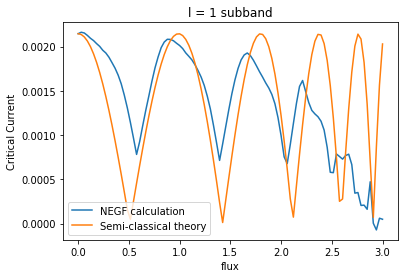

In [62]:
plt.plot(flux_vec,np.max(I_arr,axis=1),label="NEGF calculation")
plt.plot(flux_vec,np.max(I_arr,axis=1)[0]*I_c_semi,label="Semi-classical theory")
plt.ylabel("Critical Current")
plt.xlabel("flux")
plt.title("l = 1 subband")
plt.legend()

In [189]:
# sum over subbands

# Critical current vs flux for a single l subband
params = {
    "N_z" : 30,
    "t_z" : 25e-3,
    "t_phi" : 2e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 30e-3,
    "flux" : 0.0,
    "kT" : 1e-5
}

L_vec = [-1,0,1]
I_c_list = []
I_arr_list = []
st = time.time()
for l in L_vec:
    print(l)
    params["l"] = l

    E_vec = np.linspace(-1.1e-3,1.1e-3,100)
    phi_vec = np.linspace(0,2*np.pi,100)
    params['eta'] = np.abs(E_vec[1] - E_vec[0])

    flux_vec = np.linspace(0,5,100)
    I_arr = []
    for flux in flux_vec:
        params['flux'] = flux
        I_arr.append(calc_I_phi(params,E_vec,phi_vec))
    I_arr = np.array(I_arr)
    I_arr_list.append(I_arr)
print("Time:",time.time()-st)

-1
0
1
Time: 13565.736596822739


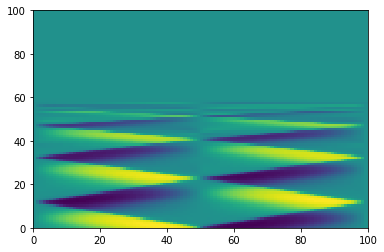

In [193]:
plt.pcolor(I_arr_list[2])

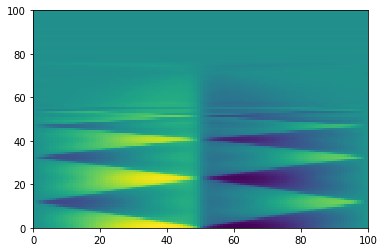

In [194]:
total_curr = I_arr_list[0] + I_arr_list[1] + I_arr_list[2]
plt.pcolor(total_curr)

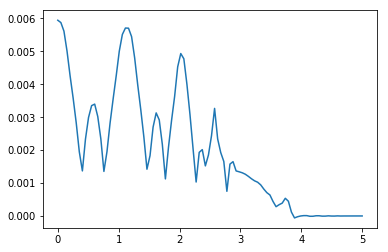

In [195]:
plt.plot(flux_vec,np.max(total_curr,axis=1))

247.38633753705963


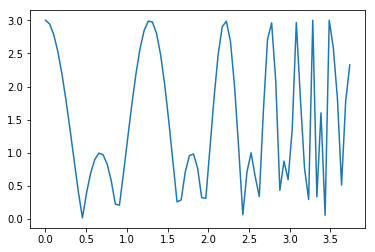

In [203]:
def calc_I_c_semi_full(flux_vec,params):
    l = 1
    L = params['N_z']*np.sqrt(1.7/params['t_z'])
    print(L)
    healing_length = 1.287*np.sqrt(params['mu'] - params['t_phi']*(l**2 + flux_vec**2))/(2*abs(params['Delta_1']))
    return np.abs(1 + 2*np.cos((L/healing_length)*(params['t_phi']*l*flux_vec/abs(params['Delta_1']))))

I_c_semi = calc_I_c_semi_full(flux_vec[:75],params)
plt.plot(flux_vec[:75],I_c_semi)

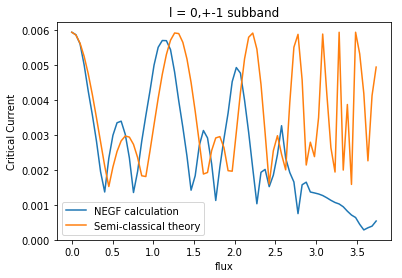

In [197]:
plt.plot(flux_vec[:75],np.max(total_curr,axis=1)[:75],label="NEGF calculation")
I_cont = 0.0015
plt.plot(flux_vec[:75],(np.max(total_curr,axis=1)[:75][0] - I_cont)*(I_c_semi/3) + I_cont,label="Semi-classical theory")
plt.ylabel("Critical Current")
plt.xlabel("flux")
plt.title("l = 0,+-1 subband")
plt.legend()

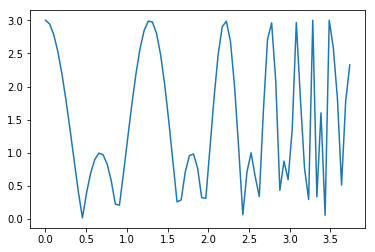

In [202]:
def I_phase_semi(omega,flux,phi_vec):
    return 2*np.sin(0.5*(phi_vec - omega*flux))*(scipy.special.expit(-np.angle(np.exp(1j*((phi_vec-omega*flux-np.pi))))*100)-0.5)

def calc_omega(l,flux,params):
    L = params['N_z']*np.sqrt(1.7/params['t_z'])
    healing_length = 1.287*np.sqrt(params['mu'] - params['t_phi']*(l**2 + flux**2))/(2*abs(params['Delta_1']))
    return (L/healing_length)*(2*params['t_phi']*l/abs(params['Delta_1']))

I_max = []
for flux in flux_vec[:75]:
    omega_l_1 = calc_omega(1,flux,params)

    I_l_0 = I_phase_semi(0,flux,phi_vec)
    I_l_1 = I_phase_semi(omega_l_1,flux,phi_vec)
    I_l_neg_1 = I_phase_semi(-omega_l_1,flux,phi_vec)

    I_tot = I_l_0 + I_l_1 + I_l_neg_1
    #I_max.append(np.max(I_tot))
    I_max.append(np.abs(1 + 2*np.cos(omega_l_1*flux*0.5)))
plt.plot(flux_vec[:75],I_max)

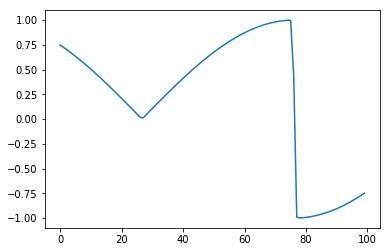

In [201]:
plt.plot(I_l_1)

# Notes
- The subband dos moves from E = 0 on changing flux, perhaps this explains depolulation on changing flux
- 230ms for N_z = 2 100 point surface_g calculation
- In the fermi function for current calculation, do I use mu or mu_e?

## Todo:
- Check Gaussian quadrature vs Simpson rule for integration

# Tests

In [9]:
# Hamiltonian 
params = {
    "N_z" : 2,
    "t_z" : 100e-3,
    "t_phi" : 4e-3,
    "Delta" : 1e-3,
    "mu" : 10e-3,
    "flux" : 0,
}

params["l"] = 0
print("l = 0")
print(calc_subband_hamiltonian(params))
    
params["l"] = 1
print("l = 1")
print(calc_subband_hamiltonian(params))

l = 0
[[ 0.19   0.001 -0.1    0.   ]
 [ 0.001 -0.19   0.     0.1  ]
 [-0.1    0.     0.19   0.001]
 [ 0.     0.1    0.001 -0.19 ]]
l = 1
[[ 0.194  0.001 -0.1    0.   ]
 [ 0.001 -0.194  0.     0.1  ]
 [-0.1    0.     0.194  0.001]
 [ 0.     0.1    0.001 -0.194]]


l = 0
l = 1


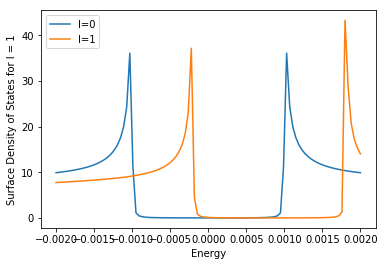

In [14]:
# surface_g 

# Hamiltonian 
params = {
    "N_z" : 2,
    "t_z" : 100e-3,
    "t_phi" : 1e-3,
    "Delta" : 1e-3,
    "mu" : 5e-3,
    "flux" : 0.4
}

print("l = 0")
params["l"] = 0
H = calc_subband_hamiltonian(params)

surface_dof = 2
alpha = H[:surface_dof,:surface_dof]
beta = H[:surface_dof,surface_dof:2*surface_dof]

E = np.linspace(-2e-3,2e-3,100)
eta = 0.1*np.abs(E[1]-E[0])

#g = calc_surface_g(E,alpha,beta,eta)
%lprun -f calc_surface_g g = calc_surface_g(E,alpha,beta,eta)

a = 1j*(g - np.conj(np.transpose(g,(0,2,1))))
dos = np.real(np.trace(a,axis1=-1,axis2=-2))

plt.plot(E,dos,label="l=0")
plt.xlabel("Energy")
plt.ylabel("Density of states")

print("l = 1")
params["l"] = -1
H = calc_subband_hamiltonian(params)

surface_dof = 2
alpha = H[:surface_dof,:surface_dof]
beta = H[:surface_dof,surface_dof:2*surface_dof]

E = np.linspace(-2e-3,2e-3,100)
eta = 0.1*np.abs(E[1]-E[0])

g = calc_surface_g(E,alpha,beta,eta)
#%lprun -f calc_surface_g g = calc_surface_g(E,alpha,beta,eta)

a = 1j*(g - np.conj(np.transpose(g,(0,2,1))))
dos = np.real(np.trace(a,axis1=-1,axis2=-2))

plt.plot(E,dos,label="l=1")
plt.xlabel("Energy")
plt.ylabel("Surface Density of States for l = 1")

plt.legend()

l = 1


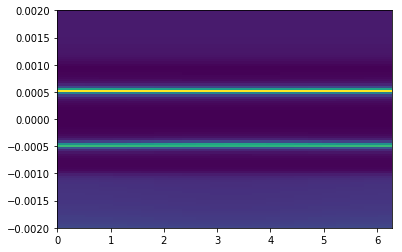

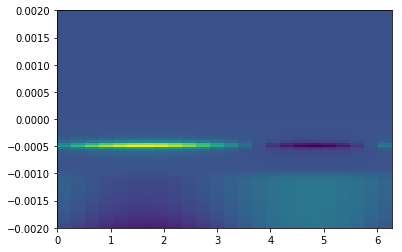

In [34]:
# sns calculation
params = {
    "N_z" : 20,
    "t_z" : 25e-3,
    "t_phi" : 2e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 30e-3,
    "flux" : 3.0,
    "kT" : 1e-5
}

print("l = 1")
params["l"] = 1

E_vec = np.linspace(-2e-3,2e-3,100)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

dos_arr = []
I_arr = []
phi_vec = np.linspace(0,2*np.pi,25)
for phi in phi_vec:
    params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
    G,A,dos,I = calc_sns_negf(E_vec,params)
    dos_arr.append(dos)
    I_arr.append(I)
    
dos_arr = np.array(dos_arr).T
XX,YY = np.meshgrid(phi_vec,E_vec)
plt.figure(1)
plt.pcolor(XX,YY,dos_arr)

I_arr = np.array(I_arr).T
XX,YY = np.meshgrid(phi_vec,E_vec)
plt.figure(2)
plt.pcolor(XX,YY,I_arr)

l = 0


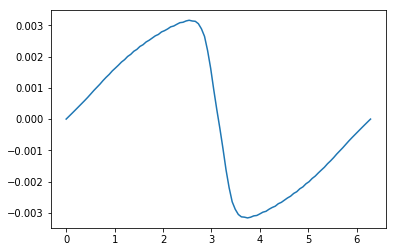

In [42]:
# current-phase
params = {
    "N_z" : 2,
    "t_z" : 100e-3,
    "t_phi" : 1e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 5e-3,
    "flux" : 0.3,
    "kT" : 1e-5
}

print("l = 0")
params["l"] = -1

E_vec = np.linspace(-2e-3,2e-3,100)
phi_vec = np.linspace(0,2*np.pi,100)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

I_phi = calc_I_phi(params,E_vec,phi_vec)
#%lprun -f calc_I_phi I_phi = calc_I_phi(params,E_vec,phi_vec)
plt.plot(phi_vec,I_phi)

In [80]:
# critical current calculation
# uses results from the above simulation
print(calc_critical_current(phi_vec,I_phi))

(0.00462192324168533, 2.3482611754105527)


# Fun

In [1]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [2]:
for i in log_progress(range(10),every=2):
    a = 2 + i
    pass

In [206]:
20*np.sqrt(1.7/params['t_z'])

164.92422502470643